# Animals-10 Dataset - Image Classification

## Introduction

The objective of this notebook is to apply and make a comparison between some pretrained models which are: ResNet50, ResNet101, vgg16 and vgg 19 and see which is better in this classification task

### Import Libraries

In [1]:
import os
import random
import cv2
import numpy as np
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import keras
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.regularizers import l2
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator as KerasImageDataGenerator

from keras.applications import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions

### Functions

In [38]:
# Function to read images and their corresponding class names
def read_images_and_classes(folder_path):
    data = []
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                image = cv2.imread(image_path)
                if image is not None:
                    data.append((image, class_name))
    return data

# Function to save images
def save_images(data, directory):
    for image, label in data:
        label_dir = os.path.join(directory, label)
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)
        image_name = f"{np.random.randint(0, 1e6)}.jpeg"  # Generate a random name for the image
        image_path = os.path.join(label_dir, image_name)
        cv2.imwrite(image_path, image)

# Function to count instances for each class in a directory
def count_instances(directory):
    class_counts = {}
    for root, dirs, files in os.walk(directory):
        for file in files:
            class_name = os.path.basename(root)
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
    return class_counts

# Function to plot images, their actual and predicted labels
def plot_images_with_labels(images, true_labels, predicted_labels, class_labels):
    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(images[i])
        plt.title(f"Actual: {class_labels[true_labels[i]]}\nPredicted: {class_labels[predicted_labels[i]]}")
        plt.axis('off')
    plt.show()

def plot_model_accuracy(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

def plot_model_loss(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

# Function to load and preprocess an image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

## Data Reading

In [40]:
# Define the path to the raw image folder
raw_img_path = "./raw-img"

# Read images and classes from the raw image folder based on the function
dataset = read_images_and_classes(raw_img_path)

Data Mapping, as the names of the classes are in different language than english

In [43]:
translate = {
    "cane": "dog",
    "cavallo": "horse", 
    "elefante": "elephant",
    "farfalla": "butterfly", 
    "gallina": "chicken", 
    "gatto": "cat", 
    "mucca": "cow", 
    "pecora": "sheep", 
    "scoiattolo": "squirrel",
    "ragno": "spider"
}

for i, (image, class_name) in enumerate(dataset):
    translated_class_name = translate.get(class_name, class_name)
    dataset[i] = (image, translated_class_name)

Display random image

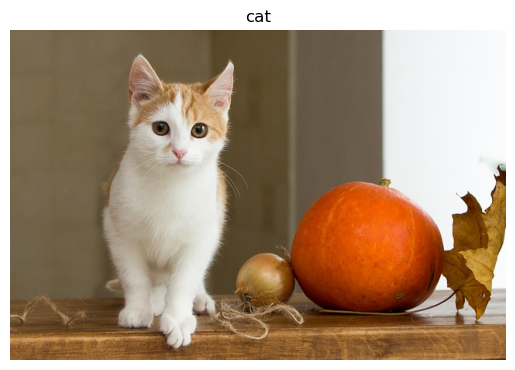

In [ ]:
# Display a random image with its class
random_image, random_class = random.choice(dataset)
plt.imshow(cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB))
plt.title(random_class)
plt.axis('off')
plt.show()

#### Checking Data Balance

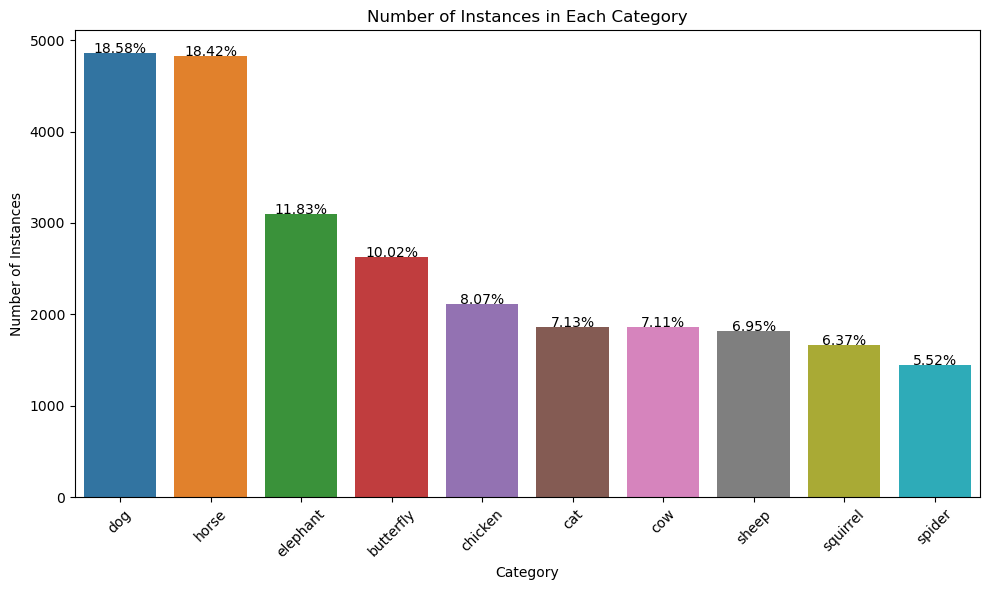

In [44]:
category_counts = {}

for _, class_name in dataset:
    if class_name in category_counts:
        category_counts[class_name] += 1
    else:
        category_counts[class_name] = 1

# Sort the category counts dictionary by the number of instances
sorted_category_counts = dict(sorted(category_counts.items(), key=lambda item: item[1], reverse=True))

# Calculate the total number of instances
total_instances = sum(sorted_category_counts.values())

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(sorted_category_counts.keys()), y=list(sorted_category_counts.values()))

# Add percentage labels above each bar
for i, (category, count) in enumerate(sorted_category_counts.items()):
    percentage = count / total_instances * 100
    plt.text(i, count + 0.5, f'{percentage:.2f}%', ha='center')

plt.title('Number of Instances in Each Category')
plt.xlabel('Category')
plt.ylabel('Number of Instances')

plt.xticks(rotation=45)
plt.gca().set_xticklabels(list(translate.values()))

plt.tight_layout()
plt.show()

As you can see from the above chart, the division between classes is imbalanced, as dog and spider classes has much more instances comparing to others,up to 4 times number of instances in elephant class which is the least one, we will see if that will have effect when we have the final results

### Data Splitting

In [ ]:
# Split the dataset into training, validation, and test sets
random.shuffle(dataset)
train_data, test_data = train_test_split(dataset, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

Saving the data in train, validation and test folders to be used for directory flow to avoid the limited memory problem, with this way we dont have to load all the data at the same time, instead we pass data in batches to the model

In [8]:
# Directory setup
base_dir = './'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

for directory in [train_dir, val_dir, test_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Save the images in the respective directories
save_images(train_data, train_dir)
save_images(val_data, val_dir)
save_images(test_data, test_dir)

In [4]:
warnings.filterwarnings('ignore', category=DeprecationWarning)

#### Reading the data from the new source

if you have already excuted this notebook before and have dowloaded the datasets after distribution, you can start from here after importing the libraries

In [25]:
train_path = './train/'
val_path = './val/'
test_path = './test/'

# Data augmentation
train_datagen = ImageDataGenerator(
    zoom_range=0.2,        
    width_shift_range=0.1,  
    height_shift_range=0.1,   
    shear_range=0.2,          
    rotation_range=25        
)
test_datagen = ImageDataGenerator()  # No augmentation for test data
val_datagen = ImageDataGenerator()  # No augmentation for validation data

# Loading datasets using flow_from_directory
train_generator = train_datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=32, shuffle=True)
test_generator = test_datagen.flow_from_directory(test_path, target_size=(224, 224), batch_size=32, shuffle=False)
val_generator = val_datagen.flow_from_directory(val_path, target_size=(224, 224), batch_size=32, shuffle=False)


Found 21166 images belonging to 10 classes.
Found 2618 images belonging to 10 classes.
Found 2356 images belonging to 10 classes.


Making sure that the distribution of instances among classes is well divided between train, validation and test sets 

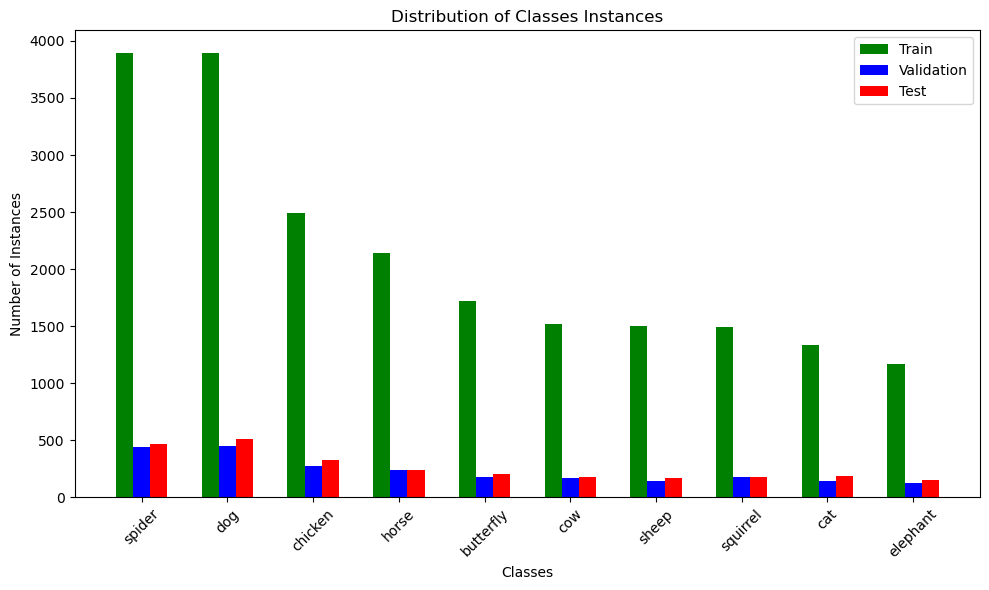

In [6]:
# Count instances for each class in train, validation, and test sets
datasets = [train_path, val_path, test_path]
class_counts = {cls: sum(count_instances(dataset).get(cls, 0) for dataset in datasets) for cls in set().union(*(count_instances(dataset).keys() for dataset in datasets))}

# Sort classes based on train set counts
sorted_classes = sorted(class_counts.items(), key=lambda item: item[1], reverse=True)
classes = [cls for cls, _ in sorted_classes]
train_counts = [class_counts[cls] for cls in classes]

# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = range(len(classes))

for i, dataset in enumerate(datasets):
    counts = [count_instances(dataset).get(cls, 0) for cls in classes]
    plt.bar([j + i * bar_width for j in index], counts, bar_width, label=dataset.split('/')[-2])

plt.xlabel('Classes')
plt.ylabel('Number of Instances')
plt.title('Distribution of Classes Instances')
plt.xticks([i + bar_width for i in index], classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## Modeling and Training

In this section, we will define several pretrained models and train them to see which is better for this task, we will use the same fine-tuning technique for all models, even it might not be 100% fair, but due to computational limitations it would be hard to expirement with each pretrained model separately until finding the best model out of each pretrained one

### ResNet50

In [27]:
model = ResNet50(
      input_shape = (224,224,3),
      include_top = False,
      weights = 'imagenet'
    )


for layers in model.layers:
  layers.trainable = False

x = Flatten()(model.output)
x = Dropout(0.3)(x)
x = Dense(10, activation = "softmax")(x)

model = keras.Model(model.input,x)
model.compile(loss="categorical_crossentropy", optimizer = "adam", metrics = "accuracy")

history = model.fit(train_generator, epochs=10, validation_data=val_generator)


Epoch 1/10
662/662 [==============================] - 3236s 5s/step - loss: 5.2473 - accuracy: 0.8322 - val_loss: 3.7152 - val_accuracy: 0.9155
Epoch 2/10
662/662 [==============================] - 3096s 5s/step - loss: 4.8151 - accuracy: 0.8902 - val_loss: 4.4826 - val_accuracy: 0.9143
Epoch 3/10
662/662 [==============================] - 2789s 4s/step - loss: 4.8496 - accuracy: 0.9074 - val_loss: 4.2516 - val_accuracy: 0.9253
Epoch 4/10
662/662 [==============================] - 2879s 4s/step - loss: 4.6844 - accuracy: 0.9143 - val_loss: 4.9918 - val_accuracy: 0.9283
Epoch 5/10
662/662 [==============================] - 2809s 4s/step - loss: 4.8216 - accuracy: 0.9172 - val_loss: 6.3602 - val_accuracy: 0.9287
Epoch 6/10
662/662 [==============================] - 2956s 4s/step - loss: 4.6254 - accuracy: 0.9266 - val_loss: 6.4943 - val_accuracy: 0.9232
Epoch 7/10
662/662 [==============================] - 2975s 4s/step - loss: 4.5195 - accuracy: 0.9308 - val_loss: 5.8247 - val_accuracy:

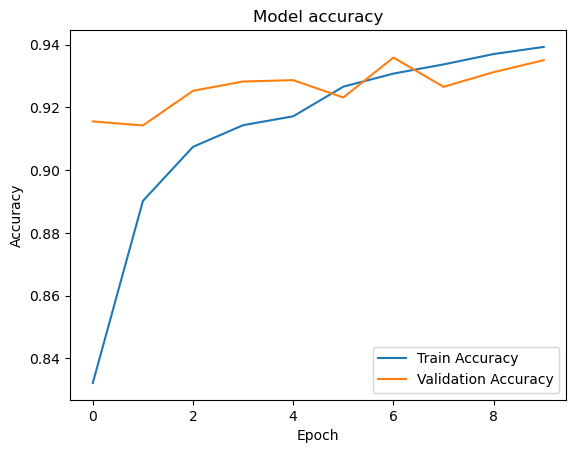

In [28]:
plot_model_accuracy(history)

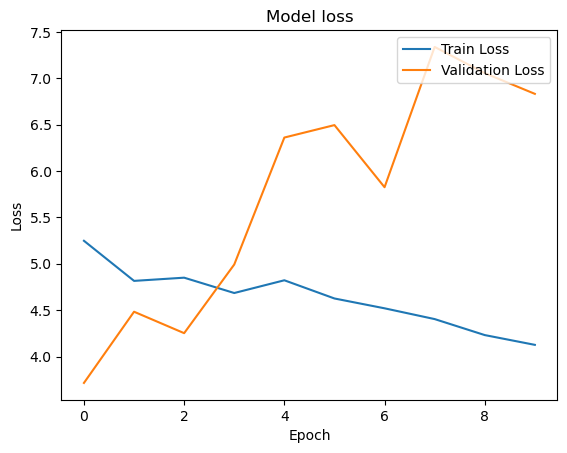

In [29]:
plot_model_loss(history)

In [30]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

82/82 [==============================] - 385s 5s/step - loss: 7.1776 - accuracy: 0.9309
Test Loss: 7.177591323852539
Test Accuracy: 0.9308632612228394


In [33]:
model.save_weights('ResNet50.h5')

The result is very good ! as we obtain an accuracy of 93% and there is no overfitting based on the chart of train-validation accuracy among epochs

## ResNet 101

In [4]:
from keras.applications import ResNet101


model = ResNet101(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

for layers in model.layers:
  layers.trainable = False

x = Flatten()(model.output)
x = Dropout(0.3)(x)
x = Dense(10, activation = "softmax")(x)

model = keras.Model(model.input,x)
model.compile(loss="categorical_crossentropy", optimizer = "adam", metrics = "accuracy")

history = model.fit(train_generator, epochs=10, validation_data=val_generator)





Epoch 1/10


662/662 [==============================] - 5309s 8s/step - loss: 5.2128 - accuracy: 0.8451 - val_loss: 3.1182 - val_accuracy: 0.9206
Epoch 2/10
662/662 [==============================] - 5205s 8s/step - loss: 4.5652 - accuracy: 0.9038 - val_loss: 4.3680 - val_accuracy: 0.9300
Epoch 3/10
662/662 [==============================] - 5220s 8s/step - loss: 4.5371 - accuracy: 0.9146 - val_loss: 4.2997 - val_accuracy: 0.9368
Epoch 4/10
662/662 [==============================] - 5309s 8s/step - loss: 4.4523 - accuracy: 0.9226 - val_loss: 4.7283 - val_accuracy: 0.9380
Epoch 5/10
662/662 [==============================] - 5251s 8s/step - loss: 4.1445 - accuracy: 0.9309 - val_loss: 4.5388 - val_accuracy: 0.9427
Epoch 6/10
662/662 [==============================] - 5177s 8s/step - loss: 3.8625 - accuracy: 0.9360 - val_loss: 4.9936 - val_accuracy: 0.9452
Epoch 7/10
662/662 [==============================] - 5177s 8s/step - loss: 3.8374 - accuracy: 0.9390 - val_loss: 5.8623 - val_accu

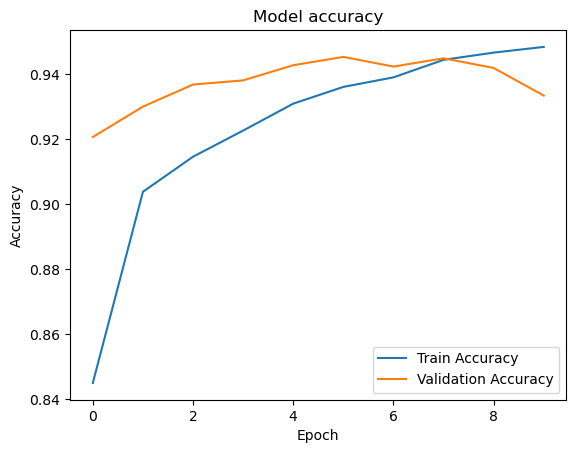

In [5]:
plot_model_accuracy(history)

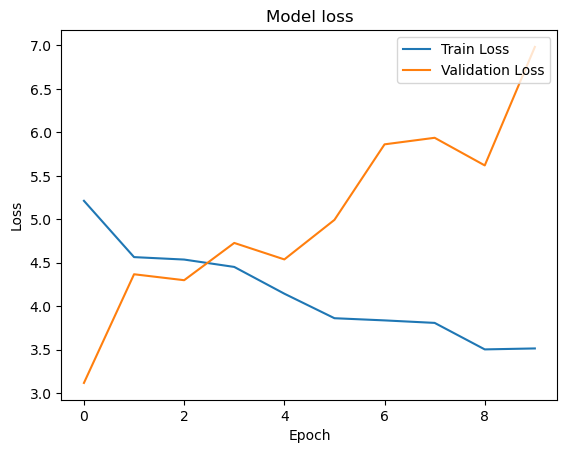

In [6]:
plot_model_loss(history)

In [7]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

82/82 [==============================] - 595s 7s/step - loss: 7.1737 - accuracy: 0.9347
Test Loss: 7.173670768737793
Test Accuracy: 0.9346829652786255


In [8]:
model.save_weights('ResNet101.h5')

The accuracy of ResNet101 model is a little bit better than ResNet50 with accuracy of 93.5%, but the cost is much bigger (almost double computation cost)

## VGG16


In [11]:

model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

for layer in model.layers:
    layer.trainable = False

x = Flatten()(model.output)
x = Dropout(0.3)(x)
x = Dense(10, activation='softmax')(x)

model = keras.Model(model.input, x)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
662/662 [==============================] - 10343s 16s/step - loss: 11.4651 - accuracy: 0.7912 - val_loss: 9.5495 - val_accuracy: 0.8871
Epoch 2/10
662/662 [==============================] - 8543s 13s/step - loss: 10.6941 - accuracy: 0.8592 - val_loss: 9.2223 - val_accuracy: 0.9104
Epoch 3/10
662/662 [==============================] - 9115s 14s/step - loss: 10.6266 - accuracy: 0.8772 - val_loss: 11.4450 - val_accuracy: 0.9160
Epoch 4/10
662/662 [==============================] - 8937s 14s/step - loss: 11.1669 - accuracy: 0.8859 - val_loss: 11.3025 - val_accuracy: 0.9070
Epoch 5/10
662/662 [==============================] - 9051s 14s/step - loss: 10.5274 - accuracy: 0.8966 - val_loss: 11.1671 - val_accuracy: 0.9202
Epoch 6/10
662/662 [==============================] - 9078s 14s/step - loss: 11.1884 - accuracy: 0.8997 - val_loss: 12.1058 - val_accuracy: 0.9198
Epoch 7/10
662/662 [==============================] - 9087s 14s/step - loss: 10.9310 - accuracy: 0.9048 - val_loss: 13.

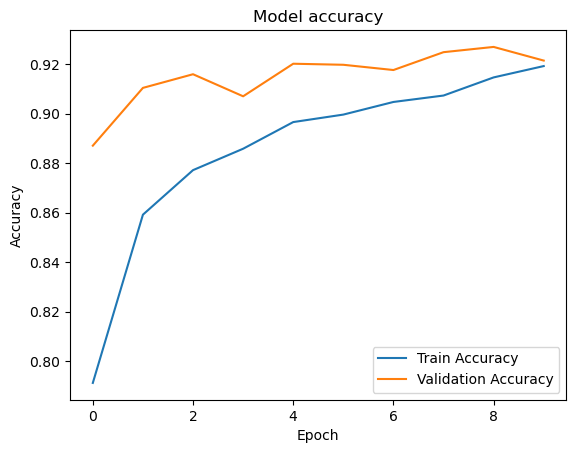

In [12]:
plot_model_accuracy(history)

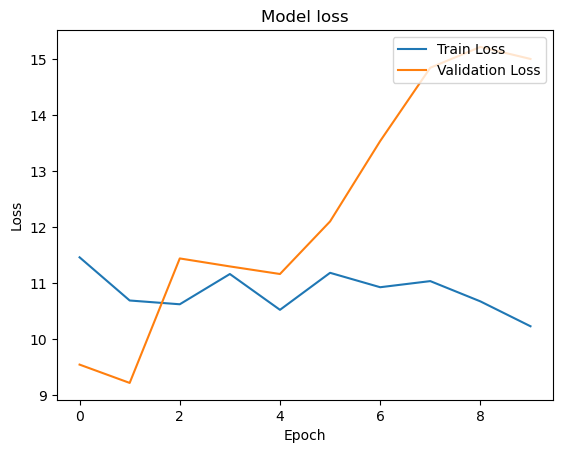

In [13]:
plot_model_loss(history)

In [14]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

82/82 [==============================] - 990s 12s/step - loss: 16.6260 - accuracy: 0.9160
Test Loss: 16.626026153564453
Test Accuracy: 0.9159663915634155


In [15]:
model.save_weights("vgg16.h5")


## VGG19

In [15]:
from tensorflow.keras.applications import VGG19

model = VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

for layer in model.layers:
    layer.trainable = False

x = Flatten()(model.output)
x = Dropout(0.3)(x)
x = Dense(10, activation='softmax')(x)

model = keras.Model(model.input, x)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
662/662 [==============================] - 11877s 18s/step - loss: 10.3582 - accuracy: 0.7956 - val_loss: 7.0699 - val_accuracy: 0.9066
Epoch 2/10
662/662 [==============================] - 12808s 19s/step - loss: 9.8941 - accuracy: 0.8630 - val_loss: 9.8189 - val_accuracy: 0.9028
Epoch 3/10
662/662 [==============================] - 13138s 20s/step - loss: 9.4271 - accuracy: 0.8825 - val_loss: 10.0269 - val_accuracy: 0.9134
Epoch 4/10
662/662 [==============================] - 13154s 20s/step - loss: 9.9519 - accuracy: 0.8913 - val_loss: 10.4033 - val_accuracy: 0.9151
Epoch 5/10
662/662 [==============================] - 13314s 20s/step - loss: 10.2745 - accuracy: 0.8926 - val_loss: 13.1175 - val_accuracy: 0.9113
Epoch 6/10
662/662 [==============================] - 12446s 19s/step - loss: 9.9645 - accuracy: 0.9014 - val_loss: 12.8788 - val_accuracy: 0.9172
Epoch 7/10
662/662 [==============================] - 11081s 17s/step - loss: 10.3720 - accuracy: 0.9057 - val_loss: 1

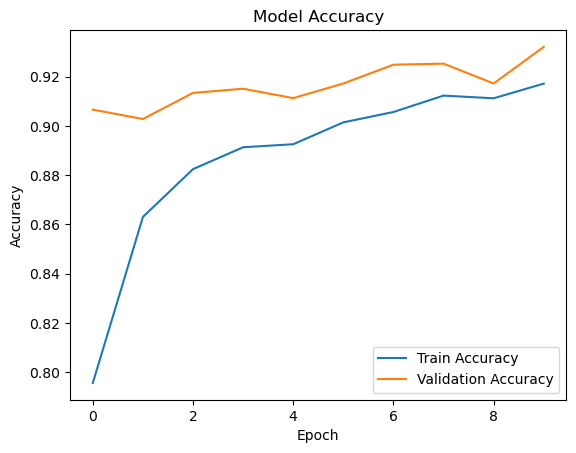

In [16]:
plot_model_accuracy(history)

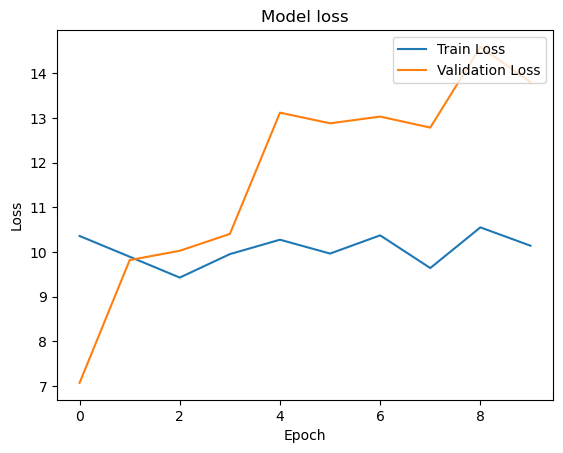

In [17]:
plot_model_loss(history)

In [18]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

82/82 [==============================] - 2266s 28s/step - loss: 15.9222 - accuracy: 0.9148
Test Loss: 15.922243118286133
Test Accuracy: 0.9148204922676086


In [19]:
model.save_weights("vgg19.h5")

#### Results Analysis

The following table shows the summary of the results for the used models, for the computational cost, CPU was used but the idea is the relative difference between the models

![alt text](image-1.png)

The accuracy of vgg models are very good but the loss is more than double ResNet models and it takes a huge time relatively for training.


Although ResNet101 has the best accuracy, I would choose ResNet50 due to the fact the large difference in the computation cost that does not justify the difference in accuracy. Therefore the winner here is ResNet50

Load the weights of best model:

In [20]:
from tensorflow.keras.models import load_model
from keras.applications import ResNet101
# Define the model architecture
model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,  # Do not include the fully connected layer at the top of the network
    weights='imagenet'  # Load weights pre-trained on ImageNet
)

# Make all layers non-trainable
for layer in model.layers:
    layer.trainable = False

# Adding custom layers
x = Flatten()(model.output)
x = Dropout(0.3)(x)  # Dropout for regularization
x = Dense(10, activation="softmax")(x)  # Final layer with 10 classes

# Creating the final model
model = Model(inputs=model.input, outputs=x)

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Load the previously saved weights
model.load_weights('ResNet50.h5')


Here, we want to show random images with the predicted and true labels, but we will read the test data another time in a different way than the test generator, becuase it's easier to access random indicies.

1/1 [==============================] - 1s 650ms/step


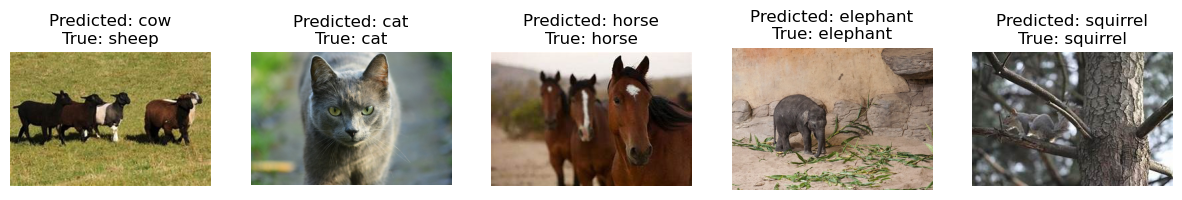

In [35]:
# Get a list of class names from the subdirectories in the test path
class_names = sorted(os.listdir(test_path))

# Plotting the images along with predicted and true labels
plt.figure(figsize=(15, 10))
for i in range(5):
    # Choose a random class
    random_class = random.choice(class_names)
    # Choose a random image from the selected class
    image_name = random.choice(os.listdir(os.path.join(test_path, random_class)))
    image_path = os.path.join(test_path, random_class, image_name)
    image_array = preprocess_image(image_path)
    
    # Predict the label
    predictions = model.predict(image_array)
    predicted_class = np.argmax(predictions)
    
    # Display the image
    plt.subplot(1, 5, i+1)
    plt.imshow(load_img(image_path))
    plt.title(f"Predicted: {class_names[predicted_class]}\nTrue: {random_class}")
    plt.axis('off')

plt.show()


#### Confusion Matrix

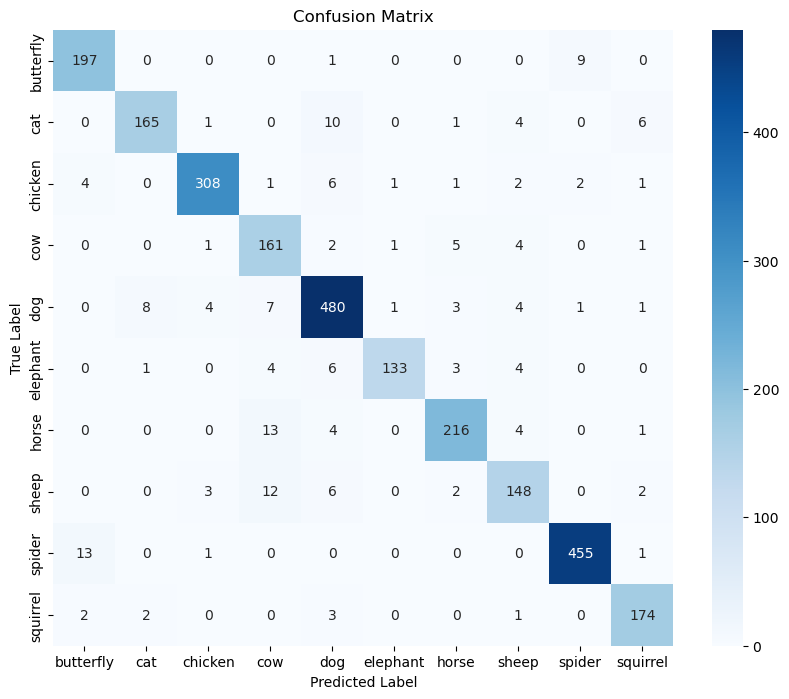

In [37]:
from sklearn.metrics import confusion_matrix, classification_report

# Get the true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the test data generator to get predictions
for i in range(len(test_generator)):
    batch = test_generator[i]
    true_labels.extend(np.argmax(batch[1], axis=1))  # Extract true labels
    predictions = model.predict(batch[0], verbose=0)  # Set verbose to 0 to suppress the progress output
    predicted_labels.extend(np.argmax(predictions, axis=1))

class_labels = list(test_generator.class_indices.keys())

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [42]:
# Calculate and display performance metrics
report = classification_report(true_labels, predicted_labels, target_names=class_labels, output_dict=True)

# Convert the dictionary to a DataFrame for a nicer table view
report_df = pd.DataFrame(report).transpose()

# Optional: round the numbers for better readability
report_df = report_df.round(2)

# Display the report
print("Performance Metrics:")
print(report_df)

Performance Metrics:
              precision  recall  f1-score  support
butterfly          0.91    0.95      0.93   207.00
cat                0.94    0.88      0.91   187.00
chicken            0.97    0.94      0.96   326.00
cow                0.81    0.92      0.86   175.00
dog                0.93    0.94      0.93   509.00
elephant           0.98    0.88      0.93   151.00
horse              0.94    0.91      0.92   238.00
sheep              0.87    0.86      0.86   173.00
spider             0.97    0.97      0.97   470.00
squirrel           0.93    0.96      0.94   182.00
accuracy           0.93    0.93      0.93     0.93
macro avg          0.92    0.92      0.92  2618.00
weighted avg       0.93    0.93      0.93  2618.00


In [45]:
# Merge performance metrics with instance counts
report_df = report_df.merge(pd.DataFrame(sorted_category_counts.items(), columns=['Category', 'Instance Count']), 
                            how='left', left_index=True, right_on='Category').set_index('Category')

# Rename the instance count column
report_df.rename(columns={'Instance Count': 'Number of Instances'}, inplace=True)

# Display the report
print("Performance Metrics:")
print(report_df)

Performance Metrics:
              precision  recall  f1-score  support  Number of Instances
Category                                                               
butterfly          0.91    0.95      0.93   207.00               2112.0
cat                0.94    0.88      0.91   187.00               1668.0
chicken            0.97    0.94      0.96   326.00               3098.0
cow                0.81    0.92      0.86   175.00               1866.0
dog                0.93    0.94      0.93   509.00               4863.0
elephant           0.98    0.88      0.93   151.00               1446.0
horse              0.94    0.91      0.92   238.00               2623.0
sheep              0.87    0.86      0.86   173.00               1820.0
spider             0.97    0.97      0.97   470.00               4821.0
squirrel           0.93    0.96      0.94   182.00               1862.0
accuracy           0.93    0.93      0.93     0.93                  NaN
macro avg          0.92    0.92      0.92  

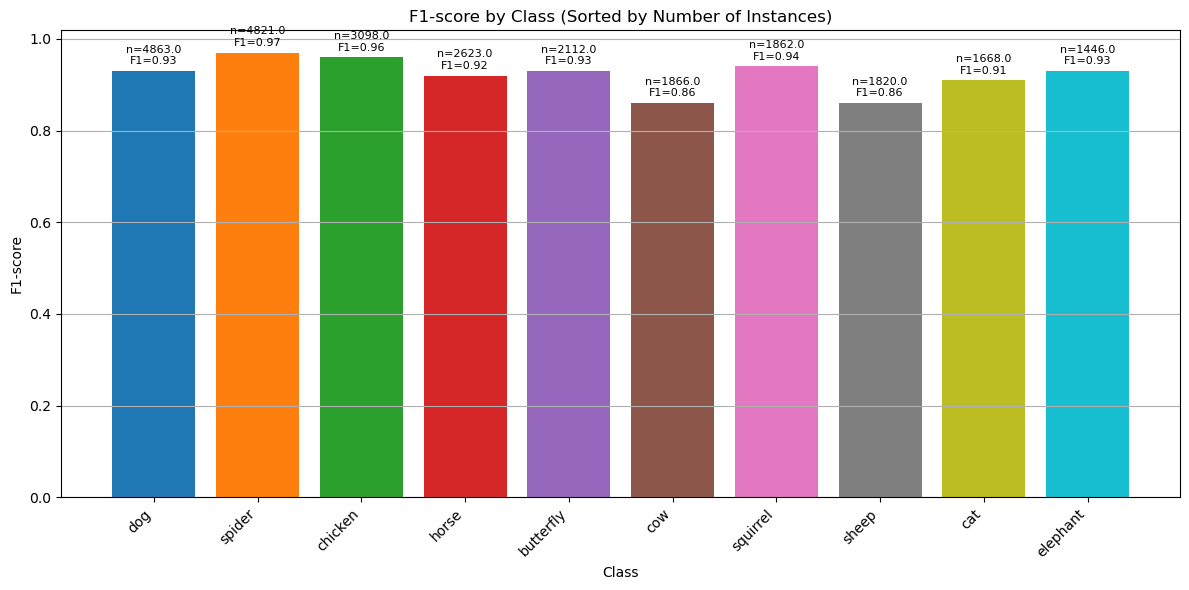

In [50]:
import numpy as np

# Sort the DataFrame by the number of instances
sorted_report_df = report_df.sort_values(by='Number of Instances', ascending=False)

# Drop rows with NaN values in the 'Number of Instances' column
sorted_report_df = sorted_report_df.dropna(subset=['Number of Instances'])

# Extract class names, F1-scores, and number of instances
class_names = sorted_report_df.index
f1_scores = sorted_report_df['f1-score']
num_instances = sorted_report_df['Number of Instances']

# Create colors for each class
colors = plt.cm.tab10(np.arange(len(class_names)))

# Create a vertical bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, f1_scores, color=colors)

# Annotate bars with n and f1-score
for bar, n, f1 in zip(bars, num_instances, f1_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'n={n}\nF1={f1:.2f}', 
             ha='center', va='bottom', fontsize=8)

plt.title('F1-score by Class (Sorted by Number of Instances)')
plt.xlabel('Class')
plt.ylabel('F1-score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

As we can see from above results: 

1- Being the data imbalanced, does not affect the results very much, as almost there is no difference in peroformance for clases that have less number of instances, as an example, the f1-score for elephant and dog classes are the same even though dogs has the heighst number of samples while elephant has the least

2- The only scores that are below 90% in all metrics are sheep and cow classes, noting that for sheep the precision and recall are almost the same (87% and 86%), while in the cow case, the precision is 81% (the lowest) and the recall is above 90%. This means that in many cases, the model was predicting a cow, while the true label is horse or a sheep.